In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt
import ipyvolume as ipv
%matplotlib inline

from tyssue.core.sheet import Sheet

from tyssue import Sheet, Monolayer, config

from tyssue.topology.monolayer_topology import cell_division

from tyssue import ClosedMonolayerGeometry as geom
from tyssue.solvers import QSSolver
from tyssue.generation import extrude


from tyssue.dynamics import effectors, model_factory

from tyssue.draw import sheet_view

from tyssue.io.hdf5 import save_datasets, load_datasets



In [8]:
datasets = load_datasets('../data/hf5/small_ellipsoid.hf5')
specs = config.geometry.bulk_spec()

monolayer = Monolayer('ell', datasets, specs)
monolayer.reset_index()
monolayer.reset_topo()
geom.update_all(monolayer)


# ## Settings for the quasi-static model
model = model_factory([effectors.LumenVolumeElasticity,
                       effectors.CellVolumeElasticity,
                       effectors.CellAreaElasticity,
                       effectors.LineTension],
                      effectors.CellVolumeElasticity)

## Initial model settings
dyn_specs = {
    "settings": {
        "lumen_side": "basal",
        "lumen_prefered_vol": monolayer.settings["lumen_vol"],
        "lumen_vol_elasticity": 10.0,
        "threshold_length": 1e-2,
    },
    "cell": {
        "prefered_vol": monolayer.cell_df.vol.mean(),
        "prefered_area": monolayer.cell_df.area.mean(),        
        "vol_elasticity": 1.0,
        "area_elasticity": 1.0,
    },
    "edge": {
        "line_tension": 0.01,
        "ux": 0.0,
        "uy": 0.0,
        "uz": 0.0,
    }
}

monolayer.update_specs(dyn_specs)



In [9]:
def test_spherical_grad():
    sheet = generation.ellipsoid_sheet(1, 1, 1, 10)
    sheet.settings["geometry"] = "spherical"
    np.testing.assert_approx_equal(
        np.linalg.norm(height_grad(sheet), axis=1).mean(), 2, 2
    )

In [2]:
from tyssue import generation
from tyssue.dynamics.sheet_gradients import height_grad
from tyssue.geometry.sheet_geometry import EllipsoidGeometry

In [6]:
sheet = generation.ellipsoid_sheet(1, 1, 1, 10)
sheet.settings["geometry"] = "spherical"
EllipsoidGeometry.update_all(sheet)
np.testing.assert_approx_equal(
    np.linalg.norm(height_grad(sheet), axis=1).mean(), 1, 2
)

In [5]:
sheet.vert_df.height

vert
181    4.107675
227    4.178281
220    4.158811
174    4.025660
321    4.106088
171    4.188241
145    4.076122
175    4.000418
251    4.171821
224    4.249590
180    4.123188
252    4.223890
176    4.008173
320    4.180348
185    4.052743
222    4.124871
212    4.342953
223    4.257414
228    4.191585
221    4.102647
173    4.280506
342    4.320345
344    4.163100
217    4.072587
82     4.294342
182    4.052743
165    4.025660
49     4.216045
274    4.280506
178    4.000418
         ...   
110    4.251673
22     4.513450
146    4.052743
24     4.611945
148    4.008173
147    4.008173
27     4.287399
127    4.926299
23     4.861992
124    4.764078
158    4.008173
119    4.442027
123    4.638921
257    4.593149
20     4.297743
118    4.441559
350    4.598951
154    4.385585
153    4.314542
113    4.171821
106    4.132569
107    4.132558
105    4.077631
26     4.213163
109    4.200888
108    4.399386
349    4.624948
258    4.761959
126    4.555940
125    4.593149
Name: height, Lengt

In [79]:
 np.linalg.norm(height_grad(sheet), axis=1).mean()

1.9690180360024239

In [51]:
monolayer.settings

{'geometry': 'cylindrical',
 'height_axis': 'z',
 'lumen_vol': 0.29248877463090095,
 'lumen_side': 'basal',
 'lumen_prefered_vol': 0.29248877463090095,
 'lumen_vol_elasticity': 10.0,
 'threshold_length': 0.01}

In [52]:
monolayer.cell_df.vol.sum()

2.7311278730512187

In [53]:
monolayer.settings['lumen_side'] = "basal"
geom.update_all(monolayer)

In [54]:
monolayer.settings["lumen_vol"]

0.29248877463090095

In [55]:
energies = model.compute_energy(monolayer, full_output=True)
print(*(f"{label.ljust(25)}: \t{np.sum(energy)/monolayer.Nc:.3e}"
      for label, energy in zip(model.labels, energies)), sep='\n')


Lumen volume elasticity  : 	0.000e+00
Volume elasticity        : 	4.448e-01
Area elasticity          : 	7.713e-03
Line tension             : 	1.803e-01


In [56]:
solver = QSSolver(with_t1=True, with_t3=True, with_collisions=True)
res = solver.find_energy_min(monolayer, geom, model)

In [57]:
print(res["message"])

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


In [58]:
def two_panels(monolayer):

    fig, (xy, zy) = plt.subplots(1, 2, sharey=True)
    fig, xy = sheet_view(monolayer, mode="quick",
                         coords=['x', 'y'],
                         ax=xy, c='k', alpha=0.3)
    fig, zy = sheet_view(monolayer, mode="quick", 
                         coords=['z', 'y'],
                         ax=zy, c='k', alpha=0.3)
    fig.set_size_inches(12, 6)
    return fig

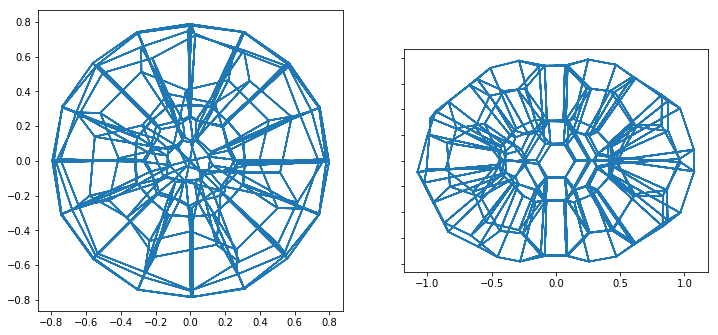

In [59]:
fig = two_panels(monolayer)

In [60]:
monolayer.face_df['visible'] = False
monolayer.face_df.loc[monolayer.basal_faces, "visible"] = True
ipv.clear()
fig, mesh = sheet_view(monolayer, mode="3D", face={"visible": True})

fig

Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

In [61]:
res['message']

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'

In [26]:
mother = 10
daughter = cell_division(monolayer, mother, orientation='vertical')


res = solver.find_energy_min(monolayer, geom, model)


In [28]:
res['message']

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'

In [29]:
monolayer.face_df['visible'] = False
monolayer.face_df.loc[monolayer.basal_faces, "visible"] = True
ipv.clear()
fig, mesh = sheet_view(monolayer, mode="3D", face={"visible": True})

fig

Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

/home/guillaume/miniconda3/envs/py37/lib/python3.7/site-packages/tyssue-0.3.1-py3.7-linux-x86_64.egg/tyssue/collisions/solvers.py:217: UserWarning: The collision was already present or its axis could not be determined
  """The collision was already present or its axis could not be determined"""


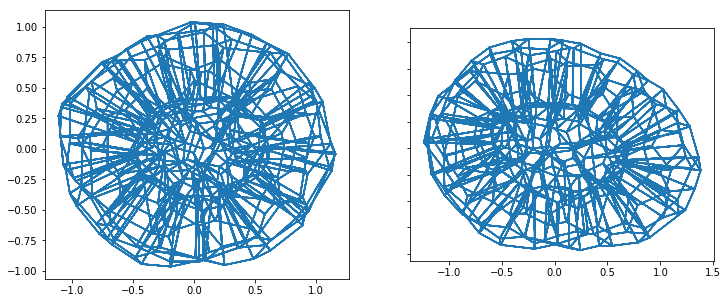

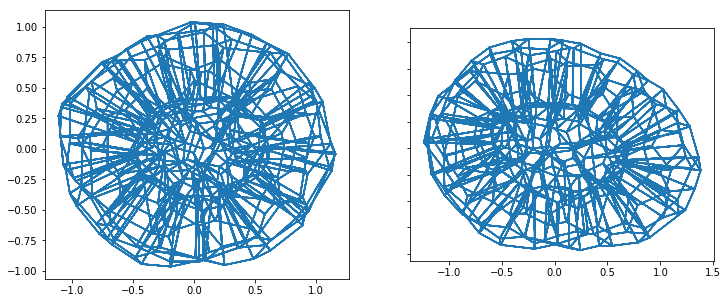

In [32]:
for cell in monolayer.cell_df.index:
    try:
        daughter = cell_division(monolayer, cell,
                                 orientation='vertical')
        res = solver.find_energy_min(monolayer, geom, model)
    except ValueError as e:
        print('Failed for cell {}'.format(cell))
        continue

monolayer.reset_index()
monolayer.reset_topo()
two_panels(monolayer)

In [22]:
from tyssue.io import obj

In [67]:
for i in range(5):
    
    monolayer.cell_df['prefered_area'] *= 1.2
    res = solver.find_energy_min(monolayer, geom, model)


In [68]:
1.2**10

6.191736422399997

In [71]:
ipv.clear()
monolayer.face_df["visible"] = True
monolayer.face_df.loc[monolayer.apical_faces, "visible"] = False

fig, mesh = sheet_view(monolayer, mode="3D",
                       face={"visible": True, "color": monolayer.face_df['area']*0.8})

fig

Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

In [70]:
res['message']

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'